<a href="https://colab.research.google.com/github/claudiasofiaC/build-week/blob/master/cleaner_build_week_notebook_!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Modeling, Module 3

# Define ML problems


##Choose your target. 

`target = 'imdbRating'`

#Is your problem regression or classification?

*Classification, by movie rating*



#How is your target distributed?

*There are ratings that a movie can receive. 1-10. The classes are definitely imbalanced.*

#Choose which observaations you will use to train, validate and test your model.

Actors: main actors in movie

ImdbID: ID for website

Genre: genre

Awards: awards of any kind

Country: country of origin

Director: name of director

Language: language of movie

Production: which company produced the movie

Rated: general movie rating

Released: release date

Runtime: duration of movie

Title: name of the movie

Year: year movie was made

ImdbRating: rating from 1-10

Person: name of the writer

Responsibility: what the person did for the movie


# **Installs**

In [0]:
%%capture
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
import pandas_profiling

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_profiling
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# **Import data** 📥
 ### partially from github and my local comp

In [4]:
# Movie_Movies dataset is way too big for github
# so uploading from local
# which is super annoying 

from google.colab import files
uploaded = files.upload()

Saving Movie_Movies.csv to Movie_Movies.csv


In [78]:
movies = pd.read_csv('Movie_Movies.csv')
print(movies.shape)
movies.columns

(178687, 18)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['Awards', 'Country', 'DVD', 'Director', 'Language', 'Plot', 'Poster',
       'Production', 'Rated', 'Released', 'Runtime', 'Title', 'Type',
       'Website', 'Year', 'imdbID', 'imdbRating', 'imdbVotes'],
      dtype='object')

In [79]:
actors = pd.read_csv('https://raw.githubusercontent.com/claudiasofiaC/build-week/master/Movie_Actors.csv?token=AMYQQCUIFXUWTXMSXMG2W2S53XCA2')
print(actors.shape)
actors.columns

(143869, 3)


Index(['Unnamed: 0', 'Actors', 'imdbID'], dtype='object')

In [80]:
genres = pd.read_csv('https://raw.githubusercontent.com/claudiasofiaC/build-week/master/Movie_Genres.csv?token=AMYQQCSN2XR5SKIJ64AV4Z253XCJ4')
print(genres.shape)
genres.columns

(308565, 3)


Index(['Unnamed: 0', 'Genre', 'imdbID'], dtype='object')

In [53]:
writers = pd.read_csv('https://raw.githubusercontent.com/claudiasofiaC/build-week/master/Movie_Writer.csv?token=AMYQQCTKRHYGBJTNTLQSBAK53XCQY')
print(writers.shape)
writers.columns

(66164, 4)


Index(['Unnamed: 0', 'Person', 'Responsibility', 'imdbID'], dtype='object')

# **Merge on 'imdbID'** 🎥  🎞 

In [0]:
movies_actors = pd.merge(movies, actors, how='inner', on='imdbID')

In [0]:
movies_actors_writers = pd.merge(movies_actors, writers, how='inner', on='imdbID')

In [0]:
full_movie_info = pd.merge(movies_actors_writers, genres, how='inner', on='imdbID')

In [84]:
print(full_movie_info.shape)
full_movie_info.head(1)

(127347, 25)


,Awards,Country,DVD,Director,Language,Plot,Poster,Production,Rated,Released,Runtime,Title,Type,Website,Year,imdbID,imdbRating,imdbVotes,Unnamed: 0_x,Actors,Unnamed: 0_y,Person,Responsibility,Unnamed: 0,Genre
0,NaN,USA,NaN,Dimitri Buchowetzki,NaN,NaN,NaN,NaN,NaN,27 Mar 1926,50 min,The Crown of Lies,movie,NaN,1926,tt0016750,NaN,NaN,2,Charles A. Post,0,Ernest Vajda,story,4,Drama


# **Trim a bit** . ✂️

In [85]:
# get rid of any movies that do not have an imdb rating
# they are useless to me!

full_movie_info_3 = full_movie_info.dropna(subset=['imdbRating'])
print(full_movie_info_3.shape)

(94926, 25)


In [86]:
full_movie_info_4 = full_movie_info_3.dropna(subset=['Director'])
print(full_movie_info_4.shape)

(94370, 25)


In [0]:
# drop what I feel are unnecessary cols
# these cols have no significance to the overall data
full_movie_info_5 = full_movie_info_4.drop(['Website', 'Unnamed: 0_x', 'Unnamed: 0_y', 
                                            'Poster', 'Unnamed: 0', 'DVD'], axis=1)

In [88]:
# arrange movies by imdbRating
sorted_movies = full_movie_info_5.sort_values(by=['imdbRating'], ascending=False)
print(sorted_movies.shape)
sorted_movies.head(1)

(94370, 19)


,Awards,Country,Director,Language,Plot,Production,Rated,Released,Runtime,Title,Type,Year,imdbID,imdbRating,imdbVotes,Actors,Person,Responsibility,Genre
90490,NaN,Greece,"Anestis Dalezis, Leonard Thimo",Greek,"""Funny Show"" is a kind of ""Dark Parody"" became...",NaN,NaN,30 Aug 2011,24 min,Funny Show: Part One,movie,2011,tt2918130,10.0,8,Leonard Thimo,Tony Meramveliotakis,original characters created by,Comedy


In [17]:
sorted_movies['imdbRating'].nunique()

90

In [52]:
sorted_movies['imdbRating'].value_counts()

6.8    3877
6.2    3825
6.3    3660
6.6    3524
6.4    3509
       ... 
9.7      11
1.4       9
1.2       9
9.5       8
9.9       2
Name: imdbRating, Length: 90, dtype: int64

In [20]:
sorted_movies.describe()

,imdbRating
count,94370.000000
mean,6.263415
std,1.158354
min,1.000000
25%,5.600000
50%,6.400000
75%,7.000000
max,10.000000


In [54]:
sorted_movies.describe(exclude = 'number')

,Awards,Country,Director,Language,Plot,Production,Rated,Released,Runtime,Title,Type,Year,imdbID,imdbVotes,Actors,Person,Responsibility,Genre
count,41867,94279,94370,93261,85465,52014,58086,88681,90718,94370,94370,94370,94370,94370,94370,94370,94370,94370
unique,1352,1205,11267,1087,15844,2225,26,10762,251,17883,1,225,18700,5649,15426,24781,2044,55
top,1 nomination.,USA,Jeff Tremaine,English,"To save her father from death in the army, a y...",Paramount Pictures,R,22 Sep 2006,90 min,Mulan,movie,2009,tt0120762,7,Mel Blanc,William Shakespeare,screenplay,Comedy
freq,5445,49739,198,56868,93,2320,14169,103,3908,93,94370,2203,93,1221,255,141,29676,9993


In [94]:
sorted_movies.isnull().sum()

Awards            52503
Country              91
Director              0
Language           1109
Plot               8905
Production        42356
Rated             36284
Released           5689
Runtime            3652
Title                 0
Type                  0
Year                  0
imdbID                0
imdbRating            0
imdbVotes             0
Actors                0
Person                0
Responsibility        0
Genre                 0
dtype: int64

In [0]:
# the mean and mode are very close
# i assume that is because most movies will recieve an overall rating that is just ok

In [0]:
# the nulls are weird in this data
# not entirely detremental to the info
# some of the movies are in multiple rows since some movies cross multiple genres

# i can not drop the rows with dups, it will leave me with 93 rows
# no awards is ok, no judgment here bro

In [67]:
sorted_movies['Director'].value_counts()

Jeff Tremaine                       198
Ron Clements, John Musker           162
Steven Spielberg                    149
William Beaudine                    137
Gary Trousdale, Kirk Wise           135
                                   ... 
Simon Staho                           1
Douglas Langway                       1
Stefanie Black, Jacquie Phillips      1
Kevin DeLullo                         1
Christoph Heller                      1
Name: Director, Length: 11267, dtype: int64

In [68]:
sorted_movies.columns

Index(['Awards', 'Country', 'Director', 'Language', 'Plot', 'Production',
       'Rated', 'Released', 'Runtime', 'Title', 'Type', 'Year', 'imdbID',
       'imdbRating', 'imdbVotes', 'Actors', 'Person', 'Responsibility',
       'Genre'],
      dtype='object')

In [142]:
sorted_movies.shape

(94370, 19)

# **Do a little cleaning** 🧼 🧽

In [0]:
def wrangle(X):


    X = X.copy()

    for col in X:
        X[col] = X[col].replace(np.nan, 0)

    # convert date_recorded to datetime
    X["Year"] = pd.to_datetime(X['Year'], infer_datetime_format=True)

    
    # Extract components from date_recorded, then drop the original column
    X['year'] = X['Year'].dt.year
    # get rid of columns that caused leakage and/or not useful
    X = X.drop(columns='Year')
    X = X.drop(columns='Released')
    X = X.drop(columns='imdbID')
    X = X.drop(columns='Title')
    X = X.drop(columns='Awards')
    X = X.drop(columns='imdbVotes')


    return X 

In [0]:
clean_movies = wrangle(sorted_movies)

In [0]:
#clean_movies[clean_movies['year'].astype(int)

In [46]:
clean_movies.dtypes

Country            object
Director           object
Language           object
Plot               object
Production         object
Rated              object
Runtime            object
Type               object
imdbRating        float64
Actors             object
Person             object
Responsibility     object
Genre              object
year                int64
dtype: object

In [140]:
clean_movies.columns

Index(['Country', 'Director', 'Language', 'Plot', 'Production', 'Rated',
       'Runtime', 'Type', 'imdbRating', 'Actors', 'Person', 'Responsibility',
       'Genre', 'year'],
      dtype='object')

In [0]:
#clean_movies['Awards'] = pd.to_numeric(clean_movies['Awards'],errors='coerce')


In [0]:
#clean_movies['imdbVotes'] = pd.to_numeric(clean_movies['imdbVotes'],errors='coerce')


In [51]:
clean_movies.head()

,Awards,Country,Director,Language,Plot,Production,Rated,Released,Runtime,Title,Type,imdbID,imdbRating,imdbVotes,Actors,Person,Responsibility,Genre,year
90490,0.0,Greece,"Anestis Dalezis, Leonard Thimo",Greek,"""Funny Show"" is a kind of ""Dark Parody"" became...",0,0,2011-08-30,24 min,Funny Show: Part One,movie,tt2918130,10.0,8.0,Leonard Thimo,Tony Meramveliotakis,original characters created by,Comedy,1970
90484,0.0,Greece,"Anestis Dalezis, Leonard Thimo",Greek,"""Funny Show"" is a kind of ""Dark Parody"" became...",0,0,2011-08-30,24 min,Funny Show: Part One,movie,tt2918130,10.0,8.0,Leonard Thimo,Anestis Dalezis,original characters created by,Comedy,1970
90495,0.0,Greece,"Anestis Dalezis, Leonard Thimo",Greek,"""Funny Show"" is a kind of ""Dark Parody"" became...",0,0,2011-08-30,24 min,Funny Show: Part One,movie,tt2918130,10.0,8.0,Leonard Thimo,Leonard Thimo,original characters created by,Short,1970
90496,0.0,Greece,"Anestis Dalezis, Leonard Thimo",Greek,"""Funny Show"" is a kind of ""Dark Parody"" became...",0,0,2011-08-30,24 min,Funny Show: Part One,movie,tt2918130,10.0,8.0,Leonard Thimo,Leonard Thimo,original characters created by,Comedy,1970
90480,0.0,Greece,"Anestis Dalezis, Leonard Thimo",Greek,"""Funny Show"" is a kind of ""Dark Parody"" became...",0,0,2011-08-30,24 min,Funny Show: Part One,movie,tt2918130,10.0,8.0,Leonard Thimo,Cries,original characters created by,Short,1970


In [22]:
clean_movies['Director'].value_counts()

Jeff Tremaine                198
Ron Clements, John Musker    162
Steven Spielberg             149
William Beaudine             137
Gary Trousdale, Kirk Wise    135
                            ... 
Shawn Burkett                  1
Viktor Polesný                 1
Shane Smith                    1
Justin Voskian                 1
Jonathan X, Tony Marshall      1
Name: Director, Length: 11267, dtype: int64

In [21]:
clean_movies['imdbRating'].value_counts(normalize = True)



6.8    0.041083
6.2    0.040532
6.3    0.038784
6.6    0.037342
6.4    0.037183
         ...   
9.7    0.000117
1.4    0.000095
1.2    0.000095
9.5    0.000085
9.9    0.000021
Name: imdbRating, Length: 90, dtype: float64

# **Fit a model** 💃🏾

In [0]:
good_stuff  = clean_movies[clean_movies['imdbRating'] >= 7]

In [0]:
unwatchable = clean_movies[clean_movies['imdbRating'] <7]

In [0]:
# splitsville

from sklearn.model_selection import train_test_split

In [0]:
# i think i'll use my good movie set for my test
# and the bad movies for train, val
# i think.
# im doing it. its done.

In [0]:
test = good_stuff

train = unwatchable

In [141]:
test.columns

Index(['Country', 'Director', 'Language', 'Plot', 'Production', 'Rated',
       'Runtime', 'Type', 'imdbRating', 'Actors', 'Person', 'Responsibility',
       'Genre', 'year'],
      dtype='object')

In [100]:
train, val = train_test_split(train, test_size=0.20, random_state=42)

train.shape, val.shape, test.shape

((54094, 14), (13524, 14), (26752, 14))

In [0]:
target = 'imdbRating'
features = train.columns.drop(target)


x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]
y_test = test[target]

In [102]:
train.dtypes

Country            object
Director           object
Language           object
Plot               object
Production         object
Rated              object
Runtime            object
Type               object
imdbRating        float64
Actors             object
Person             object
Responsibility     object
Genre              object
year                int64
dtype: object

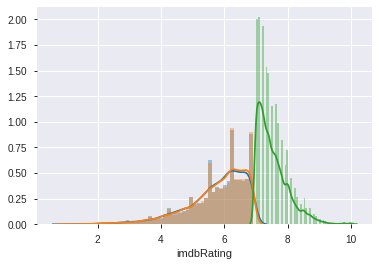

In [103]:
# completely skewed but it makes sense since this is the train set
# and with the val set
# pretty ure the buk of all ratings will fall into the midrange 5-8

%matplotlib inline
import seaborn as sns
sns.distplot(y_val);
sns.distplot(y_train);
sns.distplot(y_test);

In [54]:
clean_movies.isnull().sum()

Country           0
Director          0
Language          0
Plot              0
Production        0
Rated             0
Runtime           0
Type              0
imdbRating        0
Actors            0
Person            0
Responsibility    0
Genre             0
year              0
dtype: int64

In [0]:
# fit lin reg model

lr = make_pipeline(
    ce.TargetEncoder(),  
    StandardScaler(), 
    LinearRegression()
)



In [105]:
lr.fit(x_train, y_train)
print('Linear Regression R^2', lr.score(x_val, y_val))

Linear Regression R^2 0.7949292716667166


In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
)

x_train_transformed = transformers.fit_transform(x_train)
x_val_transformed = transformers.transform(x_val)
x_test_transformed = transformers.transform(x_test)

In [106]:
# fit gradient boosting model

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(x_train, y_train)
y_pred = gb.predict(x_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



Gradient Boosting R^2 0.1934244622074116


In [107]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

encoder = TargetEncoder()
x_train = encoder.fit_transform(x_train, y_train)
x_val = encoder.fit_transform(x_val, y_val)
x_test = encoder.fit_transform(x_test, y_test)

model = RandomForestRegressor(n_estimators=7, random_state=42, n_jobs=-1)

model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [108]:
from sklearn.metrics import r2_score
y_pred = model.predict(x_val)
print('RandomForest R^2 Score = ', r2_score(y_val, y_pred))

RandomForest R^2 Score =  0.6783648278944959


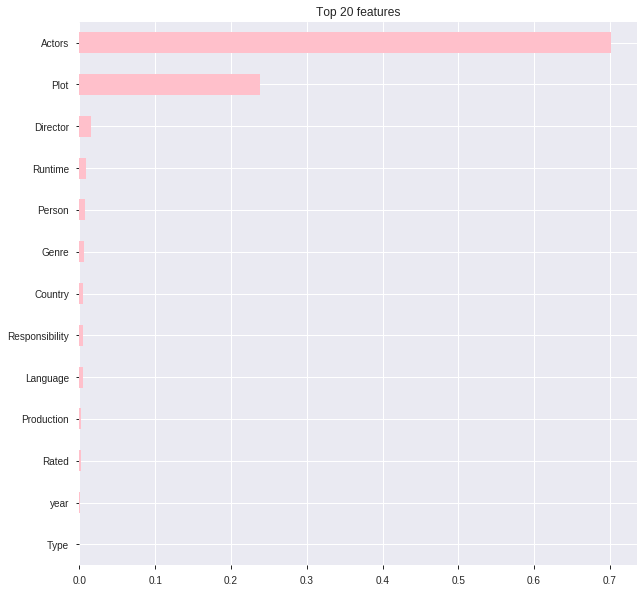

In [109]:
# Get feature importances
#rf = pipeline.named_steps['randomforestregressor']
#importances = pd.Series(rf.feature_importances_, features)
features = features
importances = pd.Series(model.feature_importances_, features)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='pink');

#**PDP and shap** 📈 📉

In [110]:
!pip install eli5


     |████████████████████████████████| 112kB 2.8MB/s 


In [111]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(x_val, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=7, n_jobs=-1,
                                                      oob_score=False,
                                                      rando

In [112]:
feature_names = x_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.4837 ± 0.0057,Plot
0.0688 ± 0.0035,Actors
0.0487 ± 0.0014,Director
0.0140 ± 0.0025,Person
0.0084 ± 0.0010,Genre
0.0026 ± 0.0020,Runtime
0.0022 ± 0.0013,Production
0.0013 ± 0.0006,Language
0.0012 ± 0.0008,Rated
0.0003 ± 0.0007,year


In [113]:
!pip install pdpbox



     |████████████████████████████████| 57.7MB 38kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=8ac4fcdf1cd4a98995dbdd0da4ddbfc196a0a65f0d3e6e7462c1060e01278db1
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [0]:
# increase dots per inch for blog post
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Director'

isolated = pdp_isolate(
    model=model, 
    dataset=x_val, 
    model_features=x_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


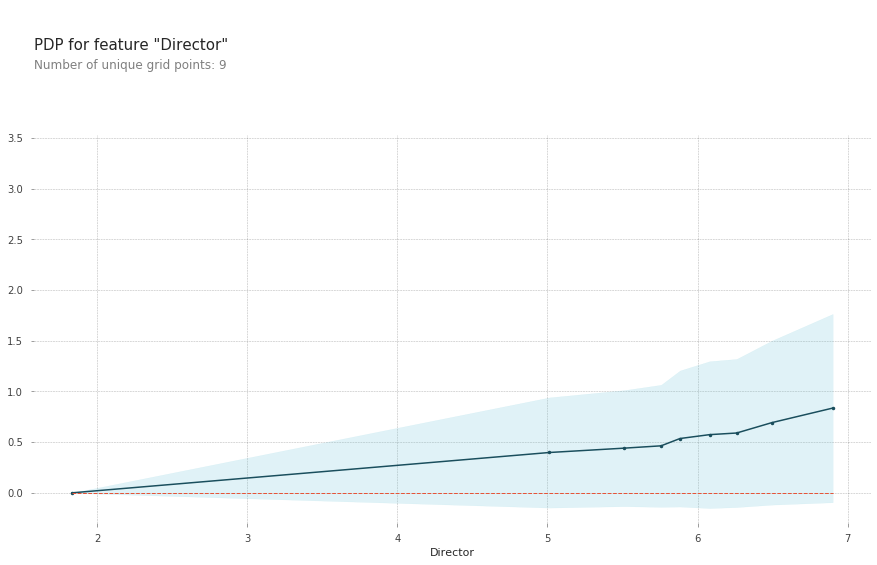

In [115]:
pdp_plot(isolated, feature_name=feature);


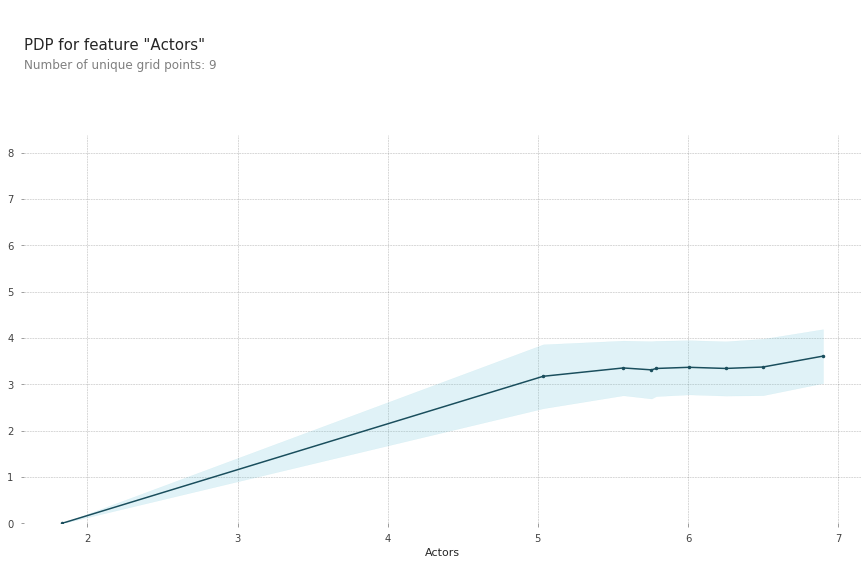

In [116]:
feature2 = 'Actors'

isolated2 = pdp_isolate(
    model=model, 
    dataset=x_val, 
    model_features=x_val.columns, 
    feature=feature2
)

pdp_plot(isolated2, feature_name=feature2);

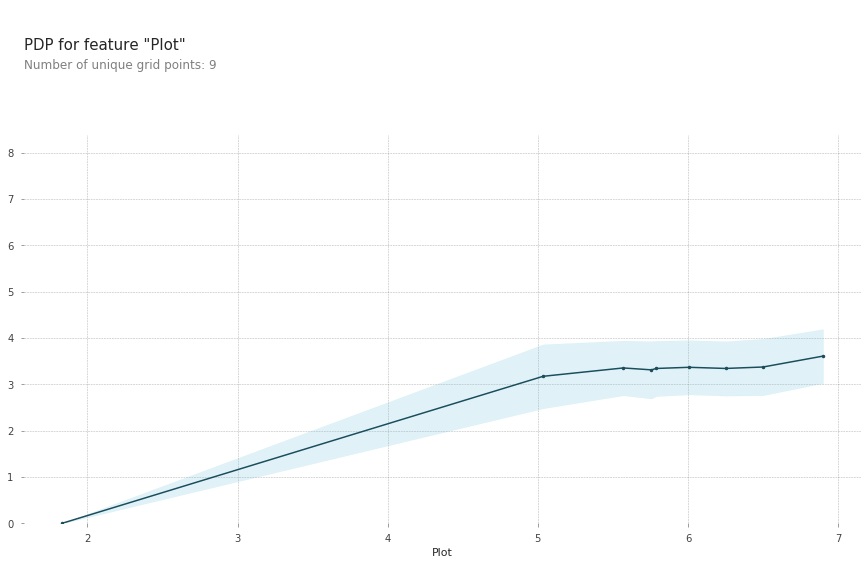

In [117]:
feature3 = 'Plot'

isolated3 = pdp_isolate(
    model=model, 
    dataset=x_val, 
    model_features=x_val.columns, 
    feature=feature3
)

pdp_plot(isolated2, feature_name=feature3);

In [0]:
feature8 = 'Actors'

isolated8 = pdp_isolate(
    model=model, 
    dataset=x_train, 
    model_features=x_train.columns, 
    feature=feature
)

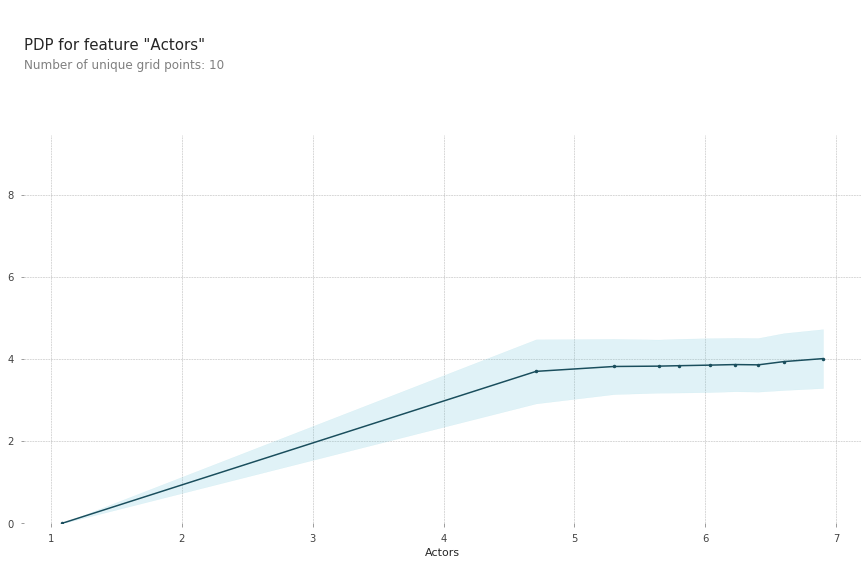

In [136]:
pdp_plot(isolated8, feature_name=feature8);

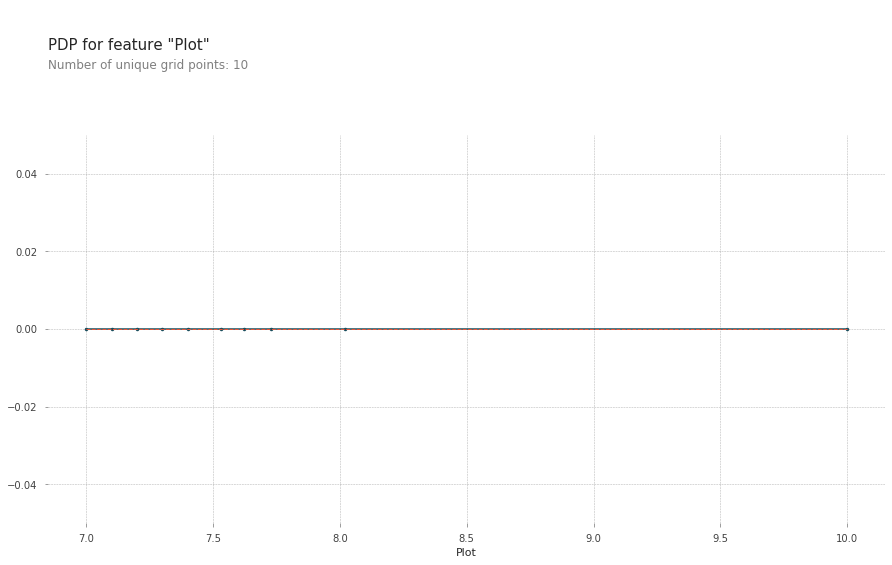

In [120]:
feature5 = 'Plot'

isolated2 = pdp_isolate(
    model=model, 
    dataset=x_test, 
    model_features=x_test.columns, 
    feature=feature5
)

pdp_plot(isolated2, feature_name=feature5);

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot


In [71]:
x_val.columns

Index(['Country', 'Director', 'Language', 'Plot', 'Production', 'Rated',
       'Runtime', 'Type', 'Actors', 'Person', 'Responsibility', 'Genre',
       'year'],
      dtype='object')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


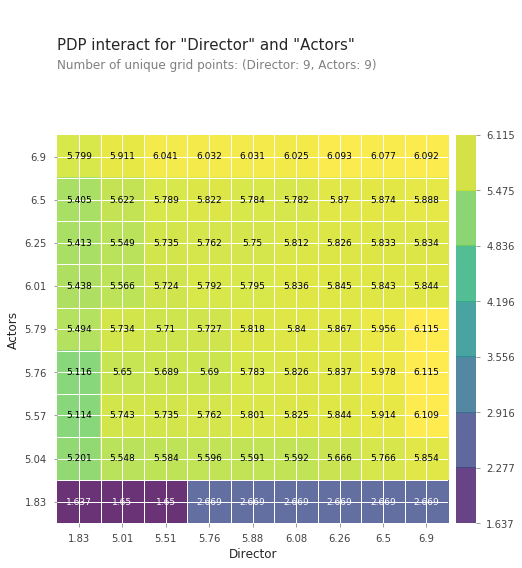

In [58]:
eval_features = ['Director', 'Actors']

interaction = pdp_interact(
    model=model, 
    dataset=x_val, 
    model_features=x_val.columns, 
    features=eval_features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=eval_features);

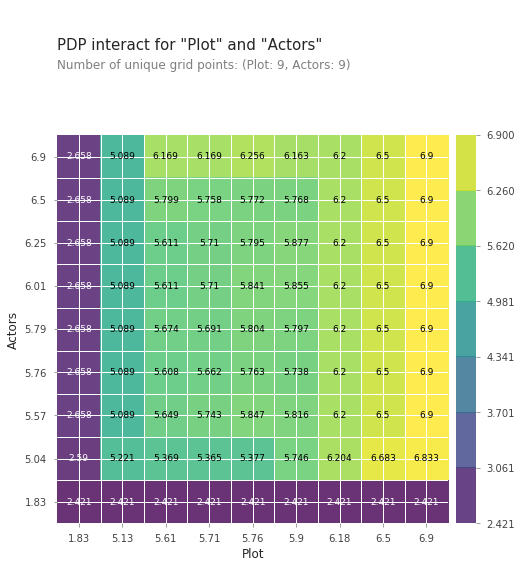

In [59]:
eval_features = ['Plot', 'Actors']

interaction = pdp_interact(
    model=model, 
    dataset=x_val, 
    model_features=x_val.columns, 
    features=eval_features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=eval_features);

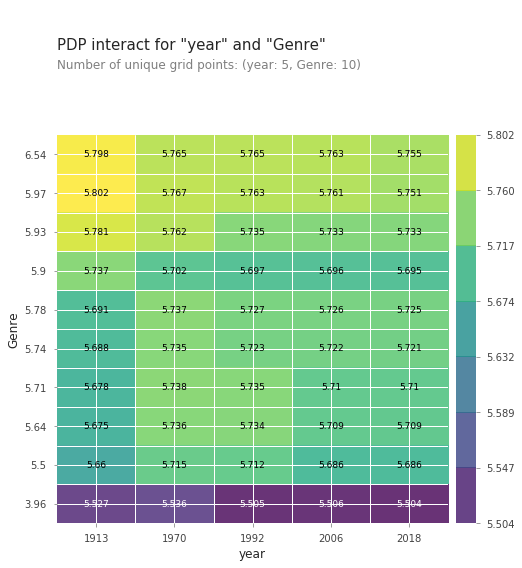

In [60]:
eval_features = ['year', 'Genre']

interaction = pdp_interact(
    model=model, 
    dataset=x_val, 
    model_features=x_val.columns, 
    features=eval_features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=eval_features);

In [121]:
!pip install shap


     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376818 sha256=232f698bc5e6c7954cf7222549e18794c7b483d4d491d82084a0a65358808ff7
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import shap

In [123]:
row1 = x_val.iloc[[0]]
row1

,Country,Director,Language,Plot,Production,Rated,Runtime,Type,Actors,Person,Responsibility,Genre,year
17891,5.224806,5.756914,5.081437,5.756914,5.713459,5.729287,5.941667,5.756914,5.756914,5.756914,5.125,5.966522,1970


In [126]:
y_val.iloc[[0]]

17891    5.0
Name: imdbRating, dtype: float64

In [80]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row1)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row1
)

In [81]:
row2 = x_val.iloc[[1000]]
row2

,Country,Director,Language,Plot,Production,Rated,Runtime,Type,Actors,Person,Responsibility,Genre,year
111008,5.776284,5.988471,5.725961,5.988471,6.095361,5.700723,5.560231,5.756914,5.988471,6.00773,5.726589,5.966522,2005


In [127]:
y_val.iloc[[1000]]

111008    6.0
Name: imdbRating, dtype: float64

In [82]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row2)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row2
)

In [91]:
y_val.iloc[1000]
#boom

6.0

In [149]:
row4 = x_test.iloc[[500]]
row4

,Country,Director,Language,Plot,Production,Rated,Runtime,Type,Actors,Person,Responsibility,Genre,year
101770,7.703486,7.529699,7.529704,7.529699,7.61167,7.616433,7.77473,7.529699,7.529699,7.529699,7.529699,7.934112,2015


In [145]:
y_test.iloc[[500]]

101770    8.8
Name: imdbRating, dtype: float64

In [150]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row4)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row4
)


# **Graph Genres through time**

In [0]:
movies.drop([ 'Awards', 'DVD', 'Poster', 'Plot', 'Website', 'Production'], axis = 1, inplace = True)

In [0]:
mg = pd.merge(movies, genres, how='inner', on='imdbID')

In [0]:
mg.drop('Unnamed: 0', axis = 1, inplace = True)

In [0]:
mg['Genre'] = mg['Genre'].apply(lambda  x : x.strip())

In [0]:
mg_time = mg
mg_time = mg_time[mg_time['imdbRating'].notnull()]
mg_time = mg_time[mg_time['Year'].notnull()].reset_index()

In [0]:
VariableTypes = {}
for year in mg_time['Year']:
    if type(year) != int:
        invalidType = type(year).__name__
        if invalidType in VariableTypes.keys():
            if year not in VariableTypes[invalidType]:
                VariableTypes[invalidType].append(year)
        else:
            VariableTypes[invalidType] = []
            VariableTypes[invalidType].append(year)

In [13]:
VariableTypes.keys()

dict_keys(['float', 'str'])

In [0]:
#clean float numbers 
#split the real Year and get the acutal information
mg_time['Year'] = mg_time['Year'].apply(lambda x : int(str(x).split(".")[0]) if type(x) == float else x)
mg_time['Year'] = mg_time['Year'].apply(lambda x : x.split("–")[0] if type(x) is str else x)
mg_time['Year'] = mg_time['Year'].apply(lambda x : int(x) if type(x) != int else x)

In [0]:
# check if everything is clean now
for row in mg_time['Year']:
    if type(row) is not int:
        print(row)
        break

In [0]:
VariableTypes = {}
for rating in mg_time['imdbRating']:
    if type(rating) != float:
        invalidType = type(rating).__name__
        if invalidType in VariableTypes.keys():
            if rating not in VariableTypes[invalidType]:
                VariableTypes[invalidType].append(rating)
        else:
            VariableTypes[invalidType] = []
            VariableTypes[invalidType].append(rating)

In [17]:
VariableTypes.keys()

dict_keys([])

In [18]:
mg_time.head(2)

,index,Country,Director,Language,Rated,Released,Runtime,Title,Type,Year,imdbID,imdbRating,imdbVotes,Genre
0,18,USA,NaN,English,NaN,NaN,10 min,Beyond Batman: Visualizing Gotham - The Produc...,movie,2005,tt1006835,6.9,35,Documentary
1,19,USA,NaN,English,NaN,NaN,10 min,Beyond Batman: Visualizing Gotham - The Produc...,movie,2005,tt1006835,6.9,35,Short


In [0]:
mg_grouped = mg_time.groupby('Genre')

In [0]:

genretop10 = mg_grouped['imdbID'].count().reset_index()

In [21]:
genretop10.sort_values('imdbID', ascending = False, inplace = True)
genretop_10 = genretop10.head(n = 10)
genretop_10.head(10)

,Genre,imdbID
8,Drama,19992
5,Comedy,14824
22,Short,13642
7,Documentary,11015
0,Action,5284
20,Romance,5003
6,Crime,4218
14,Horror,4124
25,Thriller,3993
2,Adventure,3649


In [0]:

# drop dups
Filter = []
for genre in genretop_10['Genre']:
    Filter.append(genre)

mg_time['Keep'] = mg_time['Genre'].apply(lambda genre : True if genre in Filter else False)
# we will create a new Dataframe so that we our general dataframe in our backs for potential different analysis - e.g. Genre Combination 
mg_Final = mg_time[mg_time['Keep'] == True ]

In [0]:
year_genre = mg_Final.groupby(['Year', 'Genre'])

In [25]:
Year = mg_Final.groupby('Year')
Year['imdbID'].count()

Year
1889       3
1890       3
1891       2
1894      15
1895      19
        ... 
2014    3320
2015    2782
2016    2393
2017    1639
2018     125
Name: imdbID, Length: 128, dtype: int64

In [0]:
# there arent many movies before 1990
# but between 1990 and 2017 there are a good amount

In [0]:
mg_Final_YearFilter = mg_Final[(mg_Final['Year'] >= 1990) & (mg_Final['Year'] <= 2017)]

In [0]:
year_genre = mg_Final_YearFilter.groupby(['Year', 'Genre'])

In [0]:
import seaborn as sns

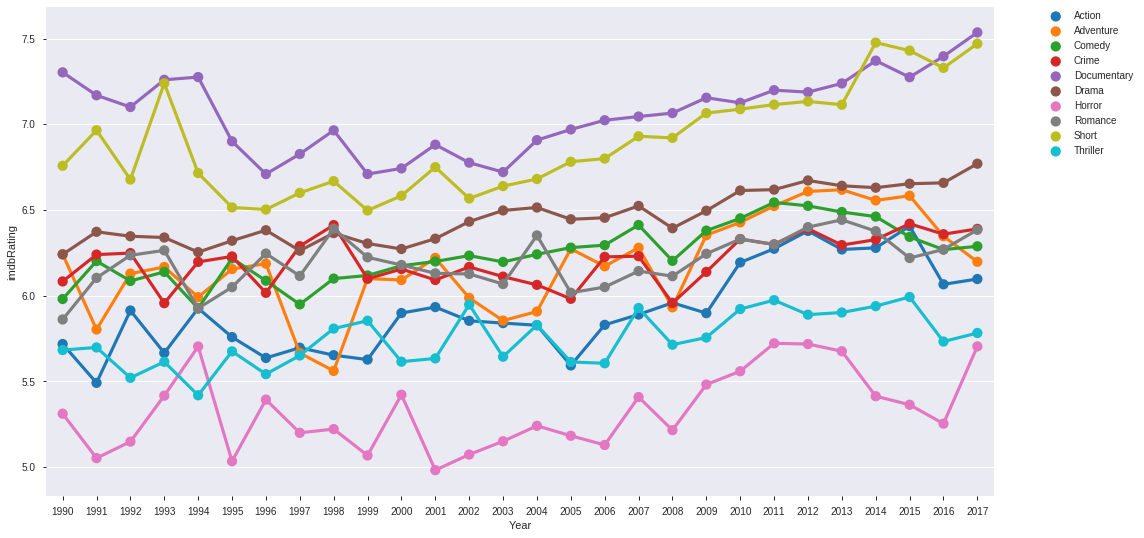

In [41]:
fig, ax = plt.subplots()

fig.set_size_inches(17, 9)
sns.pointplot(x = 'Year', y = 'imdbRating', data = year_genre['imdbRating'].mean().reset_index(), hue = 'Genre', ax = ax, legend=False)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
